In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from datetime import date
from matplotlib.ticker import FuncFormatter, PercentFormatter

sns.set_style("darkgrid")
sns.set(font_scale=1.5)
%matplotlib inline

In [2]:
def get_annual_statistics_per_airport():
    """ Return a dataframe flight counts by day of week and year  """
    engine = create_engine('sqlite:///./../../data/processed/airlines.db')
    
    with engine.connect() as conn:
        flights = pd.read_sql("""
            SELECT 
                f.origin as origin_airport,
                f.year as year,
                count(f.flights) AS departures,
                SUM(f.departure_was_delayed_15) AS departure_delays
            FROM 
                flights AS f
            WHERE 
                f.year in (2013, 2014, 2015, 2016, 2017)
            GROUP BY 
                f.origin, f.year
            ORDER BY
                departures
        """, conn)
    return flights.sort_values('departures', ascending=False)

# Get summary data for selected date range, counting flights delayed more than 15 minutes on departure
departures = get_annual_statistics_per_airport()
departures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 1599 to 0
Data columns (total 4 columns):
origin_airport      1600 non-null object
year                1600 non-null int64
departures          1600 non-null int64
departure_delays    1600 non-null int64
dtypes: int64(3), object(1)
memory usage: 62.5+ KB


In [3]:
# What are the top 25 airports by departure volume?
def get_top_airports_by_average_annual_flight_volume(data, count):
    top =  data.groupby('origin_airport').mean()[['departures']].reset_index()\
               .sort_values('departures', ascending=False).head(count)
    top = top[['origin_airport']].reset_index(drop=True)
    top['rank'] = top.index.values + 1
    return top

def generate_plot_data_for_top_airports(data, count):
    top_airports = get_top_airports_by_average_annual_flight_volume(data, count)
    # downselect data to top airports
    o = data[data['origin_airport'].isin(top_airports['origin_airport'])]
    # calculate annual rates of delay
    
    merged = o.merge(top_airports, left_on='origin_airport', right_on='origin_airport')
    
    merged['rate_of_delayed_flight'] = merged['departure_delays'] / merged['departures']
    return merged.sort_values(['rank', 'year'], ascending=True)

plot_data = generate_plot_data_for_top_airports(departures, 20)
plot_data.head()

,origin_airport,year,departures,departure_delays,rank,rate_of_delayed_flight
0,ATL,2013,398878,79937,1,0.200405
3,ATL,2014,369779,72156,1,0.195133
2,ATL,2015,379424,65363,1,0.172269
1,ATL,2016,384375,61915,1,0.161080
4,ATL,2017,364655,64570,1,0.177071


## What are the top airports by the number of average annual departing flights?

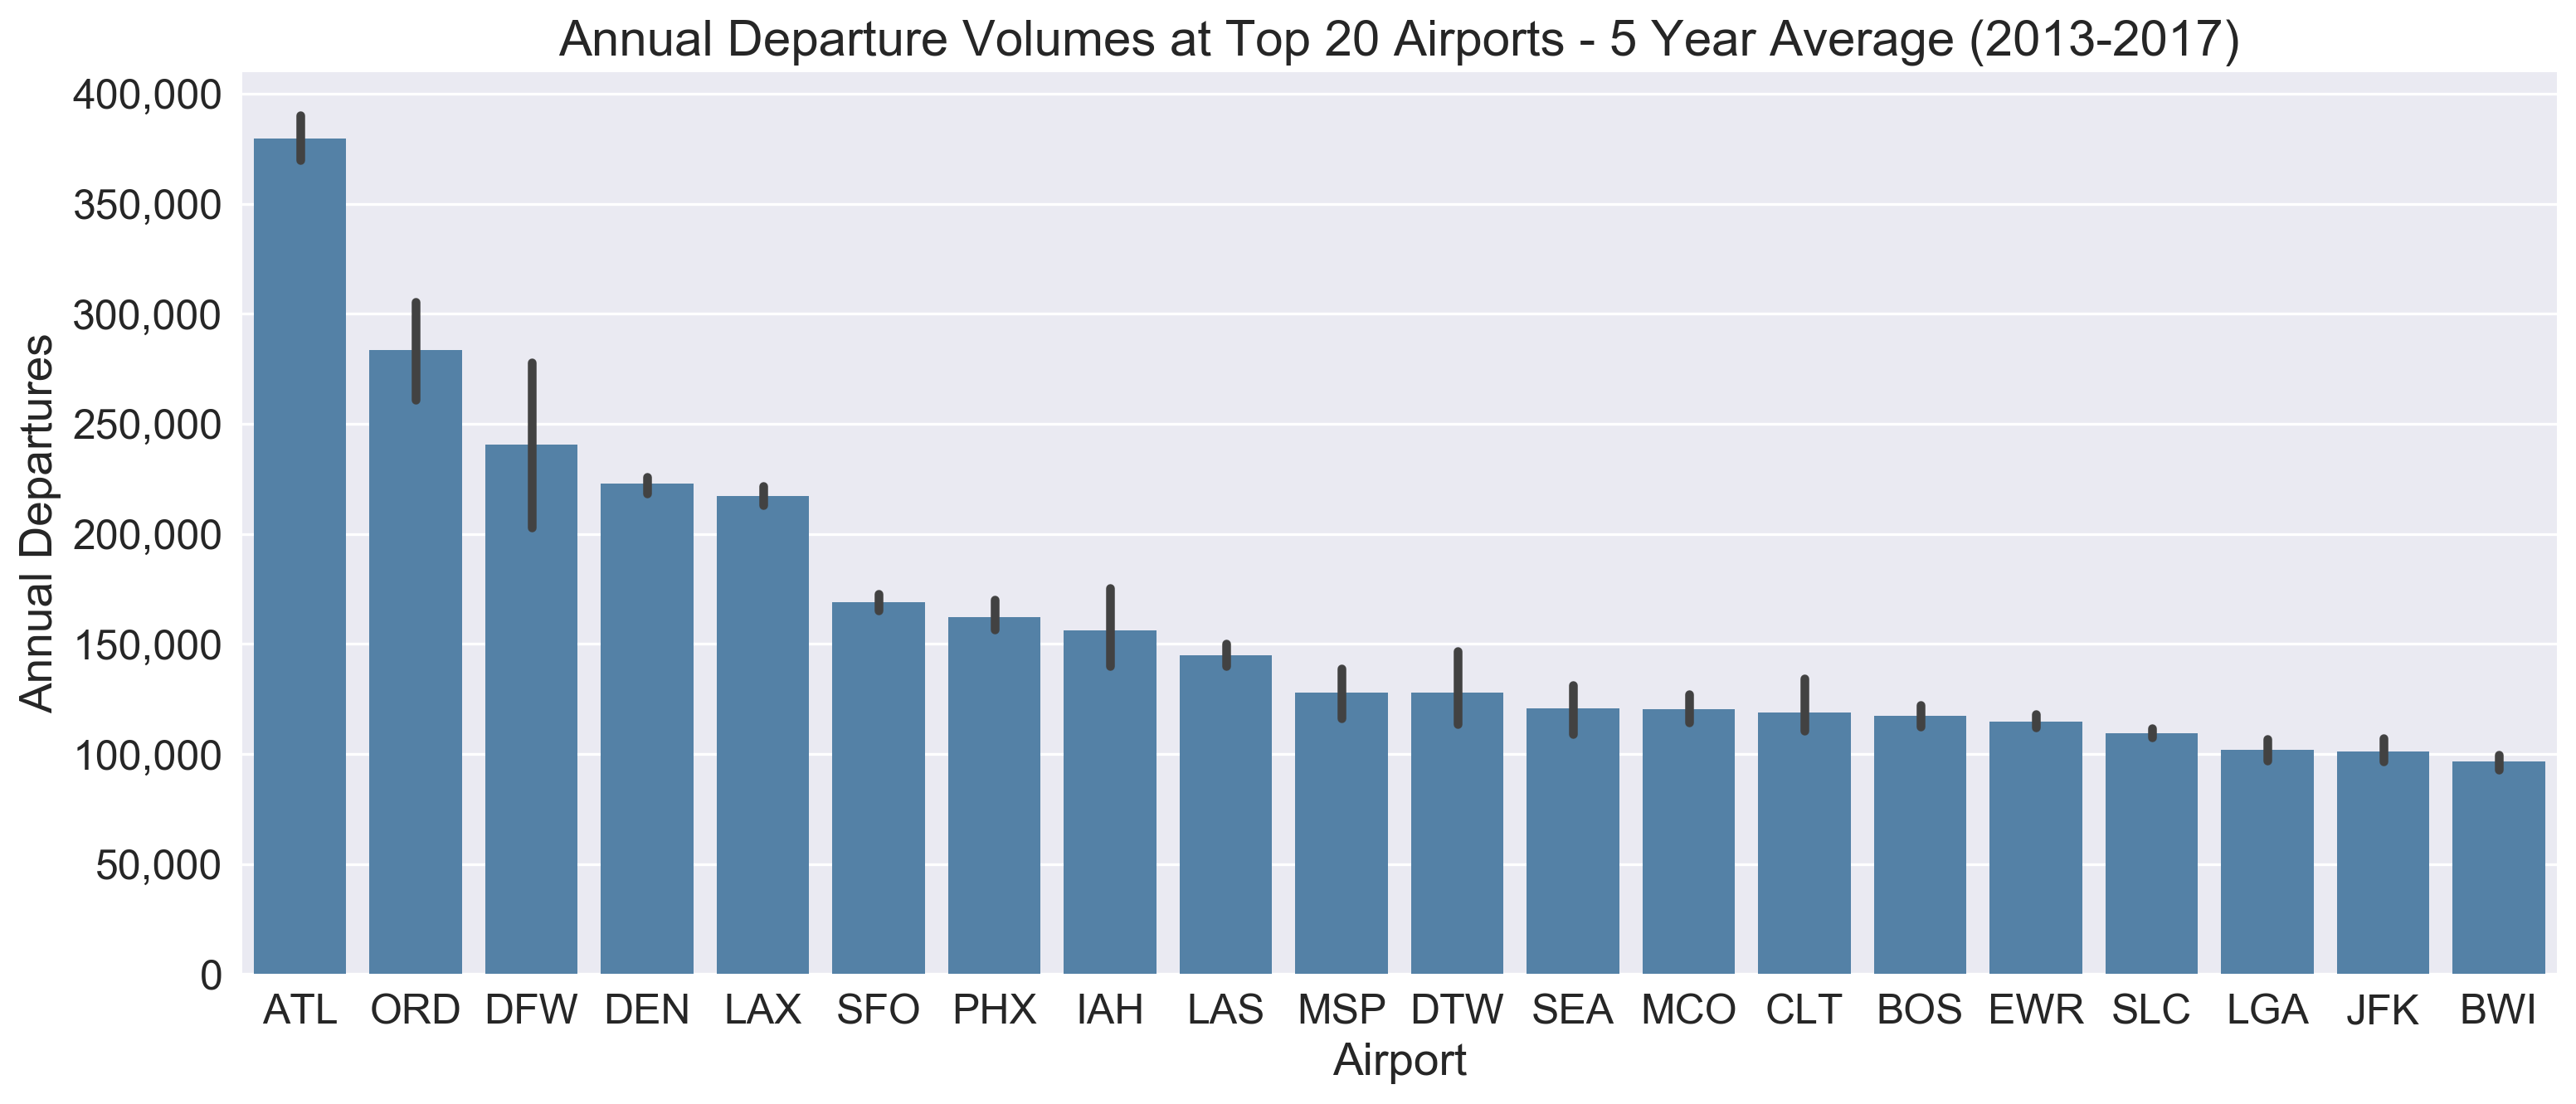

In [4]:
def plot_average_annual_departures(plot_data):
    fig, ax = plt.subplots(figsize=(15, 6), dpi=240)
    sns.barplot(x='origin_airport', y='departures', ax=ax, data=plot_data, color='steelblue')
    
    # Add , to flight counts
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

    plt.title('Annual Departure Volumes at Top 20 Airports - 5 Year Average (2013-2017)')
    plt.xlabel('Airport')
    plt.ylabel('Annual Departures')
    plt.savefig("../../reports/figures/top-airport-departure-volumes.png", bbox_inches='tight')
    plt.show()
    
plot_average_annual_departures(plot_data)

## How do the rates of departure delay vary among the top airports?

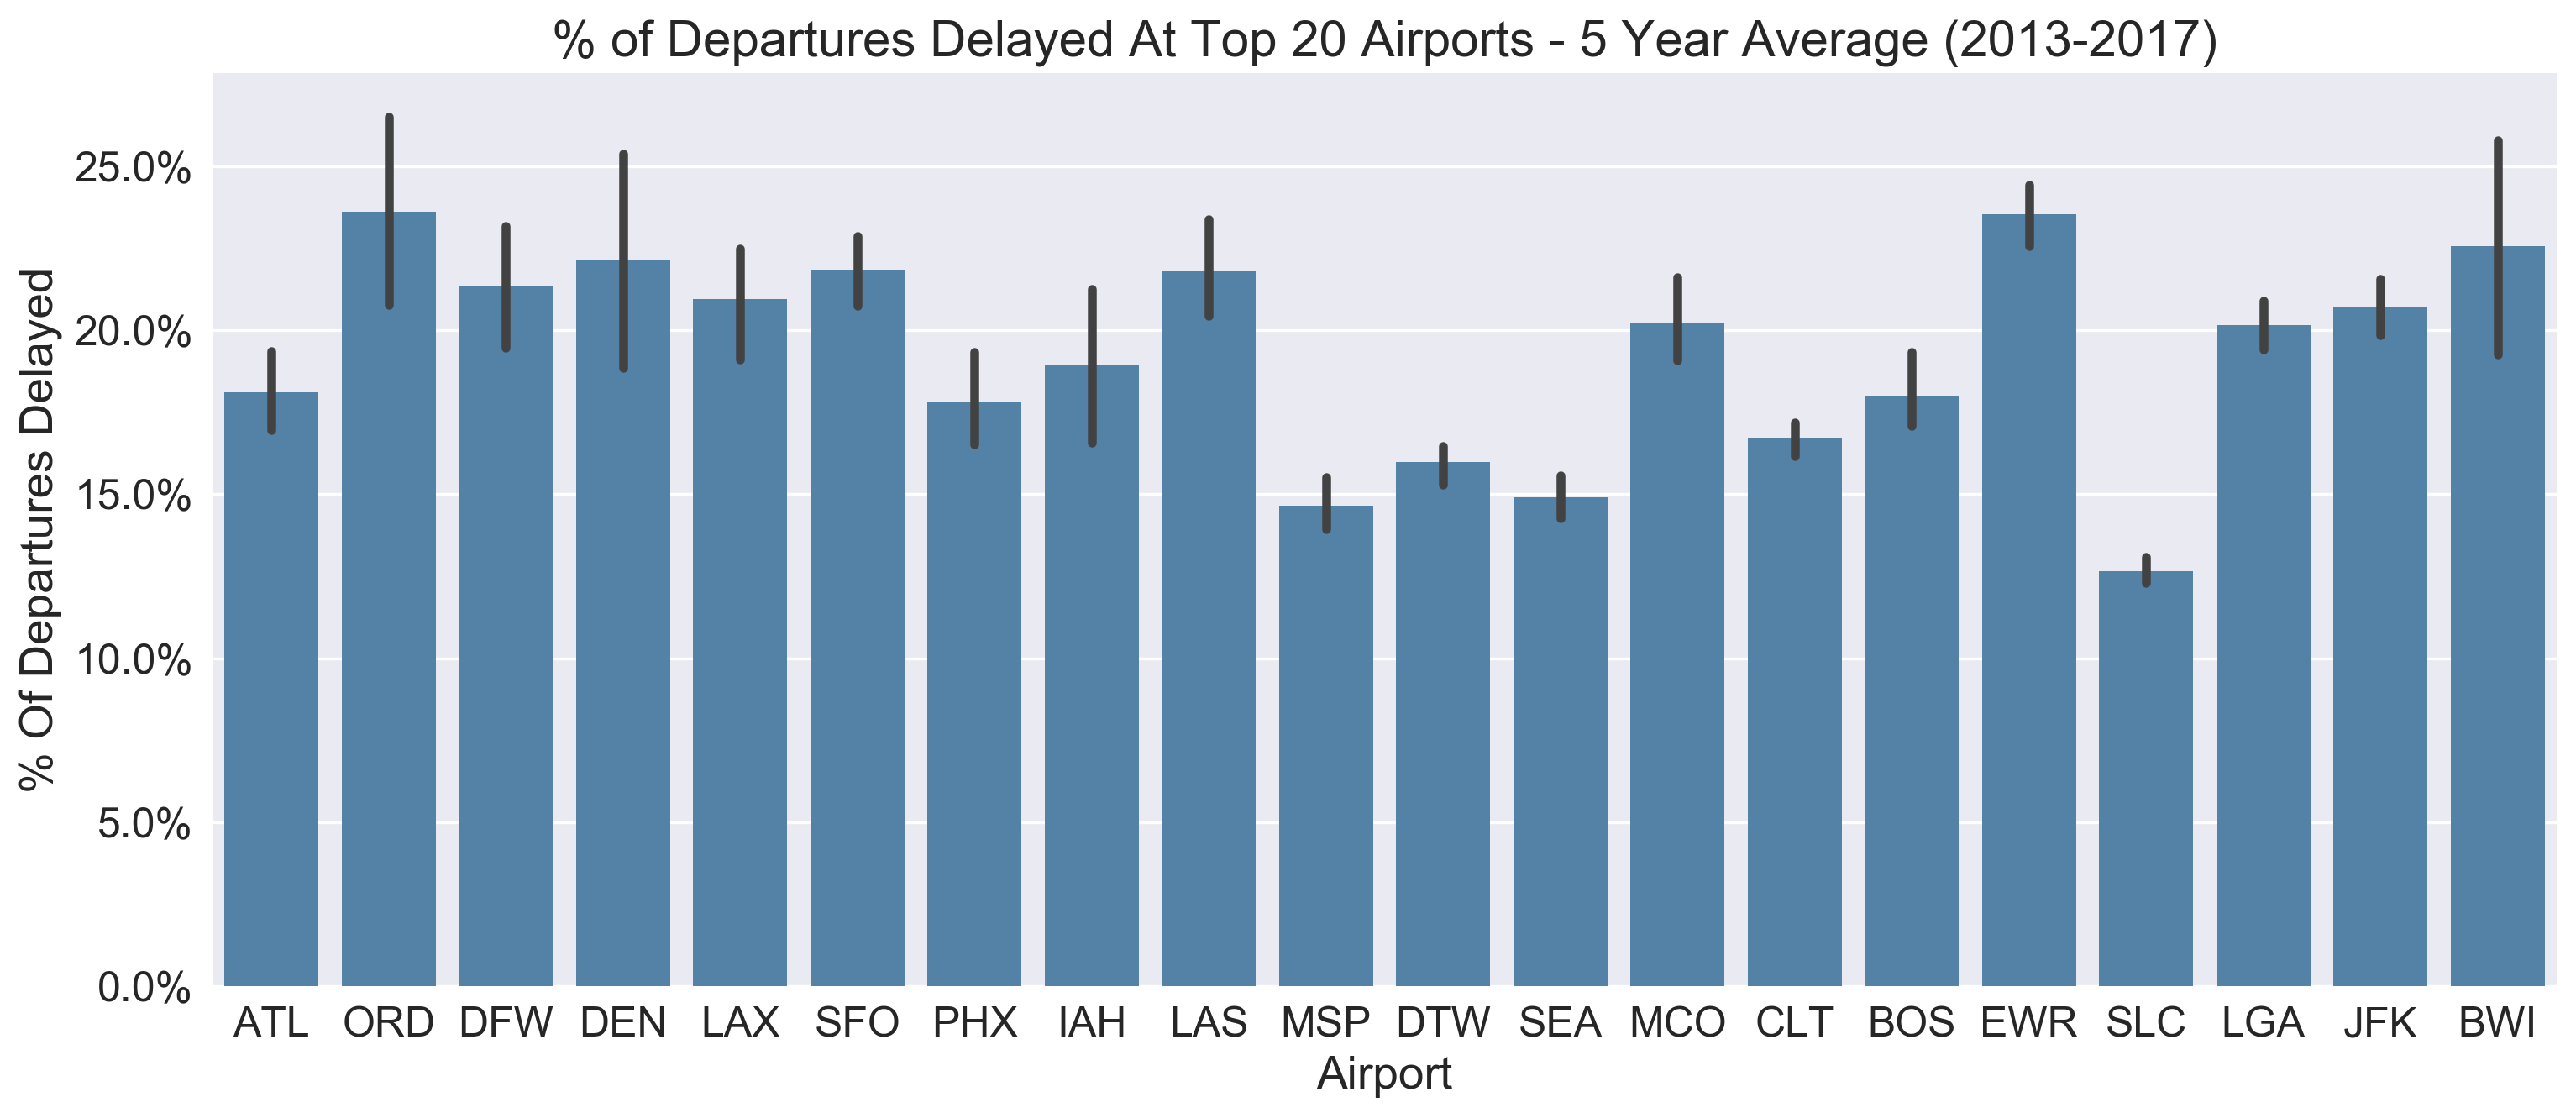

In [5]:
def plot_rates_of_departure_delay(plot_data):
    fig, ax = plt.subplots(figsize=(15, 6), dpi=240)
    sns.barplot(x='origin_airport', y='rate_of_delayed_flight', ax=ax, data=plot_data, color='steelblue')
    
    ax.get_yaxis().set_major_formatter(PercentFormatter(xmax=1))

    plt.title(f'% of Departures Delayed At Top 20 Airports - 5 Year Average (2013-2017)')
    plt.xlabel('Airport')
    plt.ylabel('% Of Departures Delayed')
    plt.savefig("../../reports/figures/top-airport-rates-of-delay.png", bbox_inches='tight')
    plt.show()
    
plot_rates_of_departure_delay(plot_data)